In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import polars as pl
from arjun_plot.utils import *

plt.rc('font', family='Arial')

%matplotlib inline 

In [2]:
meta_df=  pd.read_csv("../data/spectrum_metadata_merged.csv")
# This is a bit important for later ... 
meta_df['IID'] = meta_df.array.values

In [3]:
nsnps = 235020
pcs = pd.read_csv('../analysis/misc/results/kg_phase3.natera_merged.grch38.autosomes.phased.snvs.eigenvec', sep="\t")
pcs.rename(columns={'#IID':'IID'}, inplace=True)

In [4]:
evals=np.loadtxt('../analysis/misc/results/kg_phase3.natera_merged.grch38.autosomes.phased.snvs.eigenval')
percent_var = (evals / nsnps) * 100
percent_var

array([0.85181261, 0.43324398, 0.10311846, 0.10064207, 0.03514467,
       0.0192016 , 0.01757327, 0.01579155, 0.01142898, 0.0089669 ,
       0.0086759 , 0.00820385, 0.00809603, 0.00739865, 0.00693869,
       0.00667028, 0.00652583, 0.00629776, 0.00605255, 0.00594579])

In [5]:
kg_phase3_samples = pd.read_csv('../analysis/misc/data/sample_1kg_metadata.tsv', sep="\t")
kg_phase3_samples.rename(columns={"KGP_sample_id" : "IID"}, inplace =True)
kg_phase3_samples.head()

,IID,karyotype,superpopulation,population,unrelated
0,HG00096,XY,EUR,GBR,True
1,HG00097,XX,EUR,GBR,True
2,HG00099,XX,EUR,GBR,True
3,HG00100,XX,EUR,GBR,True
4,HG00101,XY,EUR,GBR,True


In [6]:
merged_pc_df = pcs.merge(kg_phase3_samples, how='left')
merged_pc_df.head()

,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,karyotype,superpopulation,population,unrelated
0,HG00096,-0.002910,-0.000787,0.000086,0.001923,-0.003887,0.001097,0.010945,-0.003138,0.000338,...,0.001279,0.003824,-0.006391,0.009003,-0.004834,0.005996,XY,EUR,GBR,True
1,HG00097,-0.002965,-0.000773,0.000167,0.001623,-0.003289,0.001262,0.010767,-0.003243,0.000265,...,0.003272,0.008964,0.002293,0.012830,0.003261,0.002463,XX,EUR,GBR,True
2,HG00099,-0.002896,-0.000701,-0.000078,0.001617,-0.005432,0.001421,0.010803,-0.003110,0.000327,...,-0.004131,0.008331,0.000992,0.012782,-0.004298,-0.008460,XX,EUR,GBR,True
3,HG00100,-0.002983,-0.000570,-0.000246,0.001546,-0.004020,0.001466,0.010772,-0.003050,0.000604,...,-0.000836,0.004982,-0.005214,0.012052,-0.003011,-0.003035,XX,EUR,GBR,True
4,HG00101,-0.002802,-0.000539,-0.000063,0.001534,-0.003616,0.001727,0.011035,-0.002933,-0.000129,...,0.001989,0.007389,-0.003167,0.009790,-0.001782,0.004159,XY,EUR,GBR,True


## Applying a Nearest-Neighbors Classification Approach for ancestry assignment

Here we approach this kind of simply - where for each parent we take the the top 5 nearest neighbors in the 1000 Genomes Superpopulation datasets. If the majority of the neighbors match a given superpopulation label, we assign the same label to that parent.

In [7]:
kg_phase3_df = merged_pc_df[~merged_pc_df.superpopulation.isna()]
kg_phase3_pcs = kg_phase3_df[[f'PC{i}' for i in range(1,21)]].values

# Filter those individuals out here ... 
natera_df = merged_pc_df[merged_pc_df.superpopulation.isna() & ~merged_pc_df.IID.str.contains('NA|HG')]
natera_pcs = natera_df[[f'PC{i}' for i in range(1,21)]].values

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(kg_phase3_pcs)
distances, indices = nbrs.kneighbors(natera_pcs)

pop_labels_natera = kg_phase3_df.superpopulation.values[indices]

pop_labels = []
for i in tqdm(range(pop_labels_natera.shape[0])):
    cats, counts = np.unique(pop_labels_natera[i,:], return_counts=True)
    if np.max(counts) >= 3:
        pop_labels.append(cats[np.argmax(counts)])
    else:
        pop_labels.append('NA')
        
natera_df['inferred_pop'] = pop_labels

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47684/47684 [00:01<00:00, 45553.44it/s]
/tmp/ipykernel_3731826/962444780.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  natera_df['inferred_pop'] = pop_labels


In [8]:
%time crossover_df = pl.read_csv('../analysis/co_post_process/results/v30b_heuristic_90_nsib_qual.crossover_filt.deCode_haldorsson19.merged.meta.tsv.gz', separator="\t")
parental_ids = crossover_df[['mother', 'father']].unique().to_numpy().flatten()
print(parental_ids.size)
print(parental_ids)
triplet_parents_natera_df = natera_df[natera_df.IID.isin(parental_ids)]

CPU times: user 17.4 s, sys: 2.24 s, total: 19.6 s
Wall time: 6.15 s
36550
['202013840229_R04C02' '202008260043_R01C01' '202702370089_R01C01' ...
 '203968170049_R03C01' '101274810057_R04C01' '101274810057_R03C01']


In [9]:
couples_df = triplet_parents_natera_df.merge(meta_df).groupby('casefile_id')[['array', 'inferred_pop']].agg(lambda x: ",".join(list(np.sort(x))) if len(list(x)) == 2 else np.nan).reset_index().dropna()
couples_df.head()

,casefile_id,array,inferred_pop
1,5280,"6192701074_CYTO12AB_R01C02,6192701074_CYTO12AB...","EUR,EUR"
2,7522,"6923017056_R04C01,6923017056_R05C02","EUR,EUR"
3,9500,"200910830072_R04C02,200910830072_R05C02","EUR,EUR"
4,10196,"5659787016_CYTO12AB_R05C02,7757452072_R05C01","EUR,EUR"
5,16621,"202013840078_R01C02,202013840078_R02C02","EUR,EUR"


/tmp/ipykernel_3731826/4094223449.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(xlabels, ha='right', rotation_mode='anchor', rotation=45, fontsize=8)


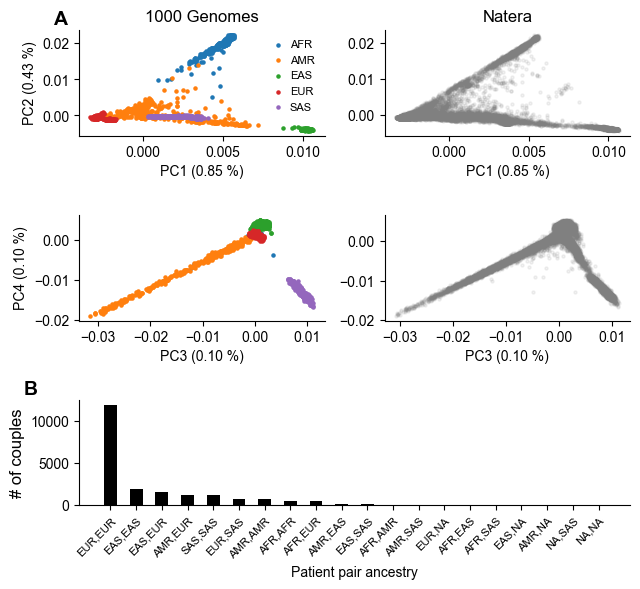

In [10]:
fig = plt.figure(figsize=(6.5, 6), tight_layout=True)
gs = GridSpec(3, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,:])

pops = np.unique(merged_pc_df[~merged_pc_df.superpopulation.isna()].superpopulation.values)
for p in pops:
    if p is not np.nan:
        cur_df = merged_pc_df[merged_pc_df.superpopulation == p]
        ax1.scatter(cur_df.PC1.values, cur_df.PC2.values, label=f'{p}', s=5)
        ax3.scatter(cur_df.PC3.values, cur_df.PC4.values, label=f'{p}', s=5)

ax2.scatter(natera_df.PC1.values, natera_df.PC2.values, color='gray', s=5, label=r'Natera', alpha=0.1)
ax4.scatter(natera_df.PC3.values, natera_df.PC4.values, color='gray', s=5, label=r'Natera', alpha=0.1)

ax1.legend(frameon=False,handletextpad=0.1, fontsize=8)
ax1.set_xlabel(f'PC1 ({percent_var[0]:.2f} %)', fontsize=10)
ax2.set_xlabel(f'PC1 ({percent_var[0]:.2f} %)', fontsize=10)
ax3.set_xlabel(f'PC3 ({percent_var[2]:.2f} %)', fontsize=10)
ax4.set_xlabel(f'PC3 ({percent_var[2]:.2f} %)', fontsize=10)
ax1.set_ylabel(f'PC2 ({percent_var[1]:.2f} %)', fontsize=10)
ax3.set_ylabel(f'PC4 ({percent_var[3]:.2f} %)', fontsize=10)
ax1.set_title('1000 Genomes', fontsize=12)
ax2.set_title('Natera', fontsize=12)

# Plotting the results for ancestry of IVF patient couples ... 
couples_ancestry_counts = couples_df['inferred_pop'].value_counts()
ax5.bar(couples_ancestry_counts.index, couples_ancestry_counts.values, width=0.5, color='black')
xlabels = ax5.get_xticklabels()
ax5.set_xticklabels(xlabels, ha='right', rotation_mode='anchor', rotation=45, fontsize=8)
ax5.set_ylabel(r'# of couples', fontsize=12)
ax5.set_xlabel(r'Patient pair ancestry')
# ax5.set_yscale('log')
# ax5.set_ylim(1,2e4)

for a in [ax1,ax2,ax3,ax4,ax5]:
    debox(a);

label_multipanel([ax1, ax5], ['A', 'B'], fontweight='bold', xoff=-0.1, fontsize=14, yoff=1.05)
plt.tight_layout()
plt.savefig('../figs/supplementary/ancestry_pca_natera_parents.081224.pdf', bbox_inches='tight')
plt.savefig('../figs/supplementary/ancestry_pca_natera_parents.081224.png', dpi=300, bbox_inches='tight')

In [11]:
try:
    natera_df[['IID', 'inferred_pop']].to_csv('../data/ancestry/natera.ancestry_labels.csv', index=None, mode='x')
except FileExistsError:
    print("Ancestry labels file already exists!")

Ancestry labels file already exists!
